In [10]:
import numpy as np
import pandas as pd
import requests
import json
import datetime
from io import StringIO
import os
from bs4 import BeautifulSoup
import time
from PIL import Image

In [11]:
import pandas as pd
import os
import datetime
import time
import requests
from bs4 import BeautifulSoup
from io import StringIO

class Fetch:
    def __init__(self, club_id:list, year:int=2024):
        self.club_id = club_id
        self.year = year

    def fetch_images(self, save_dir="images", hours=[9, 12, 15]):
        """
        Télécharge les images satellites de Météociel pour les heures spécifiées de chaque jour de l'année.
        
        Args:
            save_dir (str): Dossier où sauvegarder les images. Créé si inexistant.
            hours (list): Liste des heures de la journée à télécharger (format 24h)
        
        Returns:
            int: Nombre d'images téléchargées avec succès
        """
        # Créer le répertoire de sauvegarde s'il n'existe pas
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Initialiser le compteur d'images téléchargées
        downloaded_images = 0

        # Boucle à travers chaque jour de l'année
        for month in range(1, 13):
            for day in range(1, 32):
                try:
                    date = datetime.date(self.year, month, day)
                except ValueError:
                    continue
                for hour in hours:
                    # Formater la date et l'heure
                    date_str = date.strftime("%d-%m-%Y")
                    print(f"Date : {date_str}")
                    hour_str = f"{hour:02d}-00"
                    print(f"Heure : {hour_str}")
                    url = f"https://neige.meteociel.fr/satellite/archives/{date_str}/satvisfr-{hour_str}.jpg"

                    # Télécharger l'image
                    response = requests.get(url)
                    if response.status_code == 200:
                        # Enregistrer l'image
                        image_path = os.path.join(save_dir, f"{date_str}_{hour_str}.jpg")
                        with open(image_path, "wb") as f:
                            f.write(response.content)
                        downloaded_images += 1
                        print(f"Téléchargé : {image_path}")
                    else:
                        print(f"Erreur de téléchargement pour {url}: {response.status_code}")
        return downloaded_images

    def fetch_airports(self):
        """
        Fetches airport information for pilots from the WeGlide API.
        
        This method reads pilot IDs from 'pilots.csv', retrieves airport data for each pilot,
        and stores unique airports in 'airports.csv'.
        """
        # Check if required modules are imported
        
        try:
            # Open the pilots.csv file
            pilots = pd.read_csv("pilots.csv")
            airports_id = []
            
            # Get the pilots id
            pilots_id = pilots['ID'].tolist()
            
            for pilot_id in pilots_id:
                url = f"https://api.weglide.org/v1/user?skip=0&limit=100&id_in={pilot_id}"
                response = requests.get(url)
                response.raise_for_status()  # Raise an exception for bad status codes
                
                # The response is a json file
                data = response.json()
                
                # Check if data exists and has valid structure
                if data and len(data) > 0 and 'home_airport' in data[0] and data[0]['home_airport']:
                    airport_id = data[0]['home_airport']['id']
                    airport_name = data[0]['home_airport']['name']
                    
                    if airport_id not in airports_id:
                        # Add the airport id to the list
                        airports_id.append(airport_id)
                        
                        # Add the airport id to the csv file
                        with open('airports.csv', 'a') as f:
                            f.write(f"{airport_id},{airport_name}\n")
                            
        except FileNotFoundError:
            print("Error: pilots.csv file not found")
        except Exception as e:
            print(f"Error fetching airport data: {str(e)}")

    
    def fetch_flights(self, save_csv=True):
        """
        Fetches flight data for given club IDs and year from the WeGlide API.
        
        Args:
            save_csv (bool): Whether to save the results as a CSV file
            
        Returns:
            pandas.DataFrame: DataFrame containing flight information with unique flight IDs
        """
        dataframes = []
        
        for club in self.club_id:
            # Construct API URL with parameters
            url = (
                f"https://api.weglide.org/v1/flight?"
                f"season_in={self.year}&"
                f"airport_id_in={club}&"
                "contest=free&"
                "order_by=-scoring_date&"
                "not_scored=false&"
                "story=false&"
                "valid=false&"
                "skip=0&"
                "limit=100&"
                "include_story=true&"
                "include_stats=false&"
                "format=csv"
            )

            # Make GET request to the API
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            
            # Convert response to pandas DataFrame
            df = pd.read_csv(StringIO(response.text))
            
            # Vérifier si le DataFrame n'est pas vide
            if not df.empty:
                # Ajouter une colonne avec l'ID du club
                df['club_id'] = club
                dataframes.append(df)
        
        # Combiner tous les DataFrames
        if dataframes:
            combined_df = pd.concat(dataframes, ignore_index=True)
            
            # Vérifier les colonnes disponibles
            available_columns = combined_df.columns.tolist()
            
            # Sélectionner uniquement les colonnes souhaitées
            columns_to_keep = ['ID', 'Distance', 'Speed', 'Start', 'End', 'Date', 'club_id']
            
            # Vérifier quelles colonnes sont disponibles
            available_columns_to_keep = [col for col in columns_to_keep if col in available_columns]
            
            if available_columns_to_keep:
                combined_df = combined_df[available_columns_to_keep]
    
            return combined_df
        else:
            print("Avertissement : Aucune donnée n'a été récupérée")
            return pd.DataFrame()  # Retourner un DataFrame vide
    
    def analyse_flights(self, df):
        """
        Create a new DataFrame that counts the number of flights on a day. Calculate the mean distance and speed.
        Includes every day of the year, with zeros for days without flights.
    
        Args:
            df (pandas.DataFrame): DataFrame containing flight information
        Returns:
            pandas.DataFrame: DataFrame with columns 'Date', 'Number_of_Flights', 'Mean_Distance', 'Mean_Speed'
        """
        # Make a copy to avoid modifying the original DataFrame
        df_copy = df.copy()
        
        # Convert the 'Date' column to datetime format
        df_copy['Date'] = pd.to_datetime(df_copy['Date'])
        
        # Convert comma decimal separator to period for numeric columns
        if 'Distance' in df_copy.columns:
            df_copy['Distance'] = df_copy['Distance'].astype(str).str.replace(',', '.').astype(float)
        if 'Speed' in df_copy.columns:
            df_copy['Speed'] = df_copy['Speed'].astype(str).str.replace(',', '.').astype(float)
        
        # Create a new DataFrame with the desired columns for days with flights
        if not df_copy.empty:
            flight_data = df_copy.groupby('Date').agg({
                'ID': 'count',
                'Distance': 'mean',
                'Speed': 'mean'
            }).reset_index()
            
            flight_data.columns = ['Date', 'Number_of_Flights', 'Mean_Distance', 'Mean_Speed']
        else:
            flight_data = pd.DataFrame(columns=['Date', 'Number_of_Flights', 'Mean_Distance', 'Mean_Speed'])
        
        # Create a DataFrame with all days of the year
        start_date = pd.Timestamp(f"{self.year}-01-01")
        end_date = pd.Timestamp(f"{self.year}-12-31")
        
        # For current year, limit to today's date
        if self.year == datetime.datetime.now().year:
            end_date = pd.Timestamp(datetime.datetime.now().date())
            
        all_days = pd.DataFrame({
            'Date': pd.date_range(start=start_date, end=end_date, freq='D')
        })
        
        # Merge the flight data with all days
        new_df = all_days.merge(flight_data, on='Date', how='left')
        
        # Fill NaN values with zeros
        new_df['Number_of_Flights'] = new_df['Number_of_Flights'].fillna(0).astype(int)
        new_df['Mean_Distance'] = new_df['Mean_Distance'].fillna(0)
        new_df['Mean_Speed'] = new_df['Mean_Speed'].fillna(0)
       
        # Create a new 'flyable' column based on conditions
        new_df['flyable'] = ((new_df['Mean_Distance'] >= 50.0) & 
                     (new_df['Number_of_Flights'] >= 1)).astype(int)
        
        return new_df




fetch = Fetch(club_id=[151558, 151237, 150181, 151405], year=2024)

In [ ]:
df = fetch.fetch_flights()
fetch.analyse_flights(df).to_csv("data/flights_analysis.csv", index=False)

In [12]:
fetch = Fetch(club_id=[151558, 151237, 150181, 151405], year=2023)
fetch.fetch_images(save_dir="data_validation/image", hours=[9, 12, 15])

Date : 01-01-2023
Heure : 09-00
Téléchargé : data_validation/image/01-01-2023_09-00.jpg
Date : 01-01-2023
Heure : 12-00
Téléchargé : data_validation/image/01-01-2023_12-00.jpg
Date : 01-01-2023
Heure : 15-00
Téléchargé : data_validation/image/01-01-2023_15-00.jpg
Date : 02-01-2023
Heure : 09-00
Téléchargé : data_validation/image/02-01-2023_09-00.jpg
Date : 02-01-2023
Heure : 12-00
Téléchargé : data_validation/image/02-01-2023_12-00.jpg
Date : 02-01-2023
Heure : 15-00
Téléchargé : data_validation/image/02-01-2023_15-00.jpg
Date : 03-01-2023
Heure : 09-00
Téléchargé : data_validation/image/03-01-2023_09-00.jpg
Date : 03-01-2023
Heure : 12-00
Téléchargé : data_validation/image/03-01-2023_12-00.jpg
Date : 03-01-2023
Heure : 15-00
Téléchargé : data_validation/image/03-01-2023_15-00.jpg
Date : 04-01-2023
Heure : 09-00
Téléchargé : data_validation/image/04-01-2023_09-00.jpg
Date : 04-01-2023
Heure : 12-00
Téléchargé : data_validation/image/04-01-2023_12-00.jpg
Date : 04-01-2023
Heure : 15-00


1083

In [13]:
def crop_images(image_path, save_dir, coordinates:list):
    """
    Crop satellite images based on given coordinates and save them to a specified directory.
    
    Args:
        directory (str): Path to the images folder to be cropped.
        save_dir (str): Directory where the cropped images will be saved.
        coordinates (list): List of tuples containing coordinates for cropping.
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Loop through each image in the directory
    for filename in os.listdir(image_path):
        if filename.endswith(".jpg"):
            # Open the image
            img = Image.open(os.path.join(image_path, filename))

            # Crop the image using the provided coordinates
            for i, coord in enumerate(coordinates):
                cropped_img = img.crop(coord)
                cropped_img.save(os.path.join(save_dir, f"{filename}"))
                print(f"Cropped and saved: {filename}")
        else:
            print(f"Skipping non-jpg file: {filename}")
# Example usage
image_path = "data_validation/image"
save_dir = "data_validation/cropped_images"
coordinates = [(116, 256, 292, 388)]
crop_images(image_path, save_dir, coordinates)


Cropped and saved: 26-05-2023_09-00.jpg
Cropped and saved: 26-10-2023_09-00.jpg
Cropped and saved: 16-04-2023_09-00.jpg
Cropped and saved: 16-11-2023_09-00.jpg
Cropped and saved: 23-02-2023_09-00.jpg
Cropped and saved: 11-08-2023_09-00.jpg
Cropped and saved: 11-01-2023_15-00.jpg
Cropped and saved: 24-07-2023_15-00.jpg
Cropped and saved: 24-12-2023_15-00.jpg
Cropped and saved: 08-12-2023_09-00.jpg
Cropped and saved: 08-07-2023_09-00.jpg
Cropped and saved: 28-09-2023_12-00.jpg
Cropped and saved: 01-12-2023_12-00.jpg
Cropped and saved: 01-07-2023_12-00.jpg
Cropped and saved: 14-06-2023_15-00.jpg
Cropped and saved: 21-09-2023_09-00.jpg
Cropped and saved: 15-01-2023_09-00.jpg
Cropped and saved: 15-08-2023_15-00.jpg
Cropped and saved: 20-07-2023_09-00.jpg
Cropped and saved: 20-12-2023_09-00.jpg
Cropped and saved: 19-06-2023_12-00.jpg
Cropped and saved: 10-06-2023_09-00.jpg
Cropped and saved: 30-08-2023_12-00.jpg
Cropped and saved: 25-09-2023_15-00.jpg
Cropped and saved: 09-09-2023_09-00.jpg


In [25]:
def select_weather_data(csv_path):
    """
    Selects relevant weather data from the CSV file and returns a new DataFrame,
    filtering only for data at hours 9, 12, and 15, and excluding station ID 7117.
    
    Args:
        csv_path (str): Path to the CSV file containing weather data
    
    Returns:
        pandas.DataFrame: New DataFrame with selected columns and dates at hours 9, 12, and 15,
                         missing values filled with 0, excluding station ID 7117
    """
    # Read the CSV file
    try:
        df_weather = pd.read_csv(csv_path, sep=';', encoding='latin1', low_memory=False)
        
        # Select only the specified columns if they exist
        columns_to_keep = ['date', 'numer_sta', 'pres', 'ff', 't', 'td', 'u' ,'nbas', 'hbas', 'tminsol', 'nnuage1', 'hnuage1', 'rr12']
        available_columns = [col for col in columns_to_keep if col in df_weather.columns]
        
        if not available_columns:
            return pd.DataFrame()
        
        # Create a copy to avoid SettingWithCopyWarning
        df_filtered = df_weather[available_columns].copy()
        
        # Convert date column to datetime if it exists
        if 'date' in df_filtered.columns:
            # Try to convert date with format YYYYMMDDHHMMSS first
            try:
                df_filtered['date'] = pd.to_datetime(df_filtered['date'], format='%Y%m%d%H%M%S', errors='raise')
            except ValueError:
                # If that fails, try automatic format detection
                df_filtered['date'] = pd.to_datetime(df_filtered['date'], errors='coerce')
            
            # Filter data for the specific year
            target_year = fetch.year
            df_filtered = df_filtered[df_filtered['date'].dt.year == target_year]
            
            # Filter for only hours 9, 12, and 15
            df_filtered = df_filtered[df_filtered['date'].dt.hour.isin([9, 12, 15])]
            
            # Drop rows with invalid dates
            df_filtered = df_filtered.dropna(subset=['date'])
        
        # Filter out station ID 7117
        df_filtered = df_filtered[df_filtered['numer_sta'] != 7117]
        
        return df_filtered
    
    except FileNotFoundError:
        print(f"Error: File '{csv_path}' not found.")
        return pd.DataFrame()
    except pd.errors.EmptyDataError:
        print(f"Error: File '{csv_path}' is empty.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error processing weather data: {str(e)}")
        return pd.DataFrame()

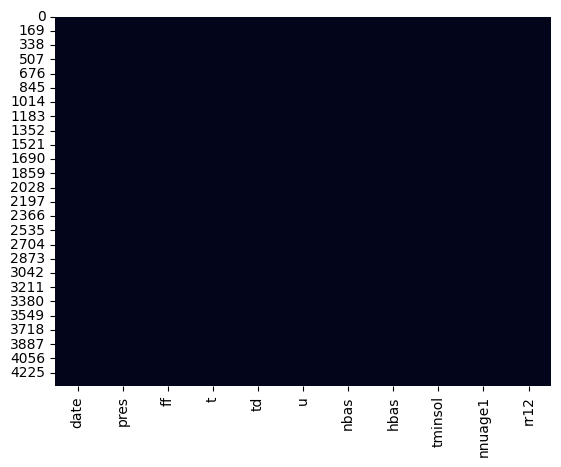

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
df = pd.read_csv('/Users/baptistecaillerie/Documents/Soaring AI/synop_files/weather_data.csv')
# Drop the hour, day, and month columns
df = df.drop(['hour', 'day', 'month', 'numer_sta', 'hnuage1'], axis=1)
# Carte de chaleur des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [256]:
print(df.isnull().sum())

date       0
pres       0
ff         0
t          0
td         0
u          0
nbas       0
hbas       0
tminsol    0
nnuage1    0
hnuage1    0
rr12       0
dtype: int64


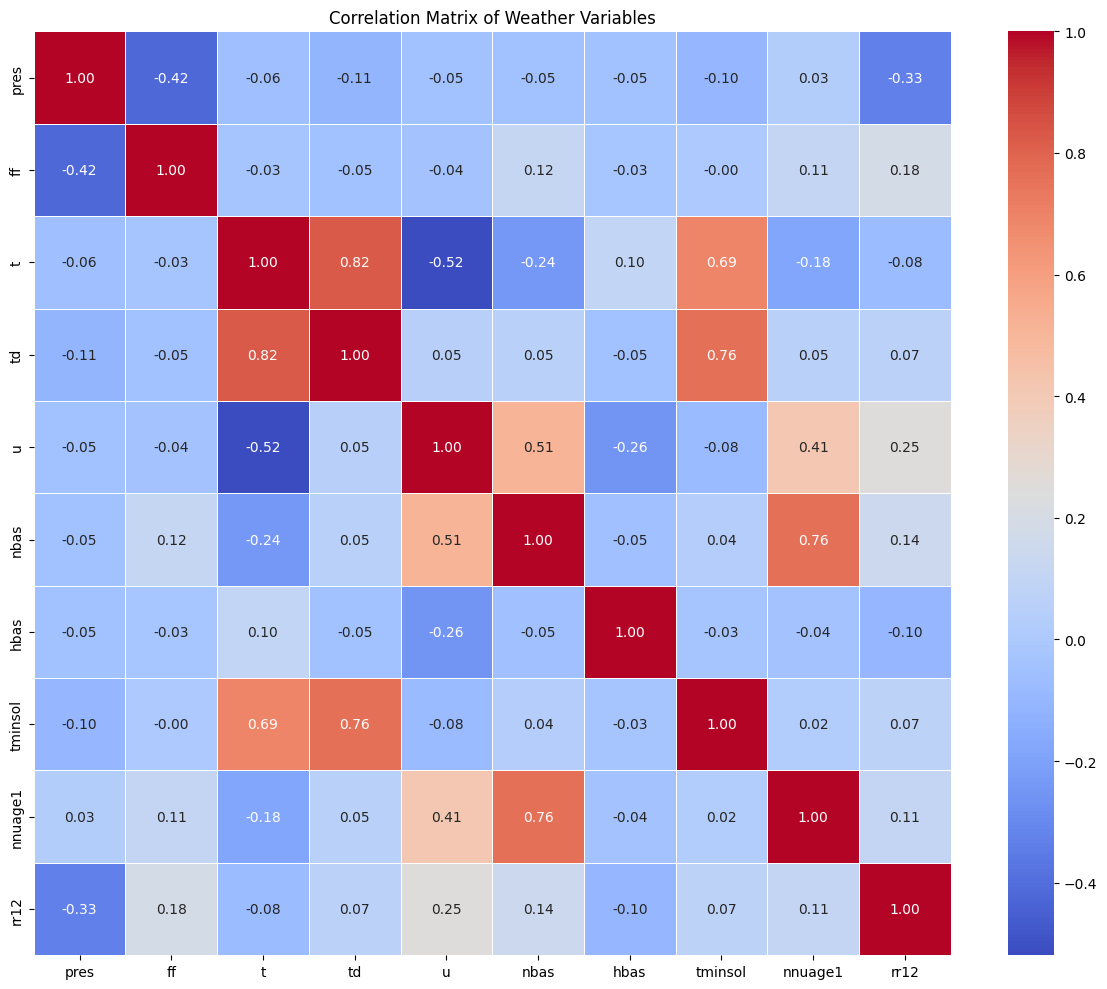

,pres,ff,t,td,u,nbas,hbas,tminsol,nnuage1,rr12
pres,1.000000,-0.422801,-0.059339,-0.110350,-0.047922,-0.046750,-0.048244,-0.101347,0.028974,-0.332980
ff,-0.422801,1.000000,-0.032328,-0.050336,-0.043130,0.115666,-0.025965,-0.002469,0.108121,0.181638
t,-0.059339,-0.032328,1.000000,0.824887,-0.519345,-0.244860,0.097985,0.692363,-0.184770,-0.078050
td,-0.110350,-0.050336,0.824887,1.000000,0.047702,0.051973,-0.046835,0.761761,0.054620,0.065690
u,-0.047922,-0.043130,-0.519345,0.047702,1.000000,0.512760,-0.256193,-0.081458,0.413786,0.247038
nbas,-0.046750,0.115666,-0.244860,0.051973,0.512760,1.000000,-0.052262,0.035635,0.758974,0.142771
hbas,-0.048244,-0.025965,0.097985,-0.046835,-0.256193,-0.052262,1.000000,-0.031340,-0.042072,-0.100764
tminsol,-0.101347,-0.002469,0.692363,0.761761,-0.081458,0.035635,-0.031340,1.000000,0.021971,0.068834
nnuage1,0.028974,0.108121,-0.184770,0.054620,0.413786,0.758974,-0.042072,0.021971,1.000000,0.107419
rr12,-0.332980,0.181638,-0.078050,0.065690,0.247038,0.142771,-0.100764,0.068834,0.107419,1.000000


In [259]:
# Create correlation matrix
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Weather Variables')
plt.tight_layout()
plt.show()

# Display the correlation matrix
correlation_matrix

In [273]:
def preprocess_data_for_model(images, synop_data, labels):
    """
    Preprocesses data to match the expected input shapes for the hybrid model.
    
    Args:
        images: List or array of satellite images (should contain 3 images per day)
        synop_data: DataFrame or array containing SYNOP weather data (3 entries per day)
        labels: Array of labels (1 per day)
    
    Returns:
        Tuple containing processed images, SYNOP data, and labels ready for the model
    """
    # Reshape images to (days, 3, height, width, channels)
    if len(images) % 3 != 0:
        print(f"Warning: Number of images ({len(images)}) is not divisible by 3")
    
    num_days = len(images) // 3
    
    # Group images by day (3 images per day)
    if isinstance(images, list):
        # If images is a list of arrays
        images_reshaped = np.array([images[i*3:(i+1)*3] for i in range(num_days)])
    else:
        # If images is already a numpy array
        images_reshaped = images.reshape(num_days, 3, *images.shape[1:])
    
    # Group SYNOP data by day (3 records per day)
    if isinstance(synop_data, pd.DataFrame):
        # Convert DataFrame to numpy array if needed
        synop_array = synop_data.values
    else:
        synop_array = synop_data
        
    if len(synop_array) % 3 != 0:
        print(f"Warning: Number of SYNOP records ({len(synop_array)}) is not divisible by 3")
    
    synop_reshaped = np.array([synop_array[i*3:(i+1)*3] for i in range(num_days)])
    
    # Labels should already be one per day
    if len(labels) != num_days:
        print(f"Warning: Number of labels ({len(labels)}) doesn't match number of days ({num_days})")
    
    # Return the reshaped data
    return images_reshaped, synop_reshaped, labels